# Flowers-17 : With Data Augmentation

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
cd gdrive/My\ Drive/DL2

/content/gdrive/My Drive/DL2


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

from tensorflow. keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
import os

Load images

In [ ]:
imagePaths = list(paths.list_images("./datasets/flowers17/images"))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

In [ ]:
len(classNames)

17

Define preprocessor

In [ ]:
def AspectAwarePreprocessor(image, width, height): 
    (h, w) = image.shape[:2]
    dW = 0
    dH = 0

    if w < h:
        image = imutils.resize(image, width=width)
        dH = int((image.shape[0] - height) / 2.0)

    else:
        image = imutils.resize(image, height=height)
        dW = int((image.shape[1] - width) / 2.0)

    (h, w) = image.shape[:2]
    image = image[dH:h - dH, dW:w - dW]


    return cv2.resize(image, (width, height))

Create images and labels dataset

In [ ]:
# initialize the list of features and labels
data = []
labels = []
verbose = 500

# loop over the input images
for (i, imagePath) in enumerate(imagePaths):

    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-2]
    
    # Preprocessing using AspectAwarePreprocessor() 
    # instead of cv2.resize
    #
    #image = cv2.resize(image, 64, 64)
    image = AspectAwarePreprocessor(image, 64,64)


    data.append(image)
    labels.append(label)

    # show an update every `verbose` images
    if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
        print("[INFO] processed {}/{}".format(i + 1,
            len(imagePaths)))
        
data = np.array(data) 
labels = np.array(labels)

data = data.astype("float") / 255.0

[INFO] processed 500/1360
[INFO] processed 1000/1360


Split Train/Test dataset

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, 
                                                  labels,
                                                  test_size=0.25, 
                                                  random_state=42)

Convert labels to one-hot encode

In [ ]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

Data augmentation

* rotation : +/-30 degree
* width shift : 10%
* height shift : 10%
* shear : 20%
* zoom in/out : 20%
* horizontal flip : True
* fill mode : nearest

In [ ]:
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         fill_mode='nearest',
                         horizontal_flip=True

)

Define MiniVGGNet model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

Compiling model

In [ ]:
opt = SGD(lr=0.05)
model = MiniVGGNet.build(width=64, height=64, depth=3,
                         classes=len(classNames))

model.compile(loss = "categorical_crossentropy", 
              optimizer = opt,
              metrics = ["accuracy"])

Training network

In [ ]:
H = model.fit(aug.flow(trainX, trainY, batch_size=32),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX)//32,
              epochs=100, verbose=1
)

Epoch 1/100
31/31 [==============================] - 2s 79ms/step - loss: 3.3154 - accuracy: 0.2156 - val_loss: 3.1691 - val_accuracy: 0.1441
Epoch 2/100
31/31 [==============================] - 2s 59ms/step - loss: 2.4205 - accuracy: 0.3451 - val_loss: 2.6820 - val_accuracy: 0.2000
Epoch 3/100
31/31 [==============================] - 2s 60ms/step - loss: 1.9717 - accuracy: 0.4241 - val_loss: 2.7504 - val_accuracy: 0.2176
Epoch 4/100
31/31 [==============================] - 2s 61ms/step - loss: 1.7288 - accuracy: 0.4889 - val_loss: 2.7480 - val_accuracy: 0.2294
Epoch 5/100
31/31 [==============================] - 2s 62ms/step - loss: 1.6702 - accuracy: 0.4889 - val_loss: 2.7065 - val_accuracy: 0.2912
Epoch 6/100
31/31 [==============================] - 2s 63ms/step - loss: 1.6546 - accuracy: 0.4919 - val_loss: 2.8878 - val_accuracy: 0.2353
Epoch 7/100
31/31 [==============================] - 2s 64ms/step - loss: 1.6500 - accuracy: 0.4848 - val_loss: 2.4697 - val_accuracy: 0.3059
Epoch 

Evaluating network

In [ ]:
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=classNames))

              precision    recall  f1-score   support

    bluebell       0.75      0.80      0.77        15
   buttercup       0.67      0.84      0.74        19
   coltsfoot       0.65      0.68      0.67        19
     cowslip       0.74      0.67      0.70        21
      crocus       0.40      0.80      0.53        20
    daffodil       0.67      0.61      0.64        23
       daisy       0.95      0.90      0.92        20
   dandelion       0.79      0.75      0.77        20
  fritillary       0.81      0.81      0.81        16
        iris       1.00      0.63      0.77        27
  lilyvalley       0.82      0.64      0.72        22
       pansy       1.00      0.50      0.67        20
    snowdrop       0.73      0.44      0.55        18
   sunflower       1.00      1.00      1.00        16
   tigerlily       0.92      0.96      0.94        23
       tulip       0.37      0.39      0.38        18
  windflower       0.62      0.87      0.73        23

    accuracy              

Plot the training loss and accuracy

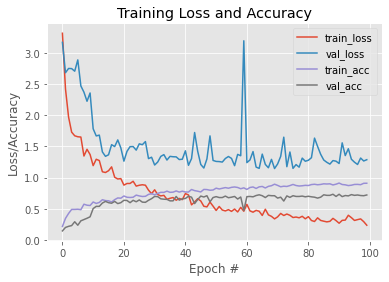

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()